# Installing packages

In [1]:
%pip install transformers seaborn sentencepiece
%pip install --upgrade --no-cache-dir gdown > /dev/null

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Importing libraries and config

In [2]:
import gdown
import os
import logging
import sys


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from time import time
from collections import Counter
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from torch.optim import AdamW
from warnings import filterwarnings
from transformers import MarianMTModel, MarianTokenizer
from functools import partial
from collections import defaultdict

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configuring libraries
logging.basicConfig()
tqdm.pandas()
filterwarnings('ignore')


# Remove all handlers associated with the root logger object.
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to output to stdout, which should display in a Kaggle notebook.
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('app')

In [4]:
# %pip install --no-cache-dir --upgrade kaggle

In [5]:
# Installing Kaggle CLI used for pushing notebook to kaggle if working elsewhere
# %%bash
# !gdown 1GkE7Y9FYq2sczsusvhWsvvRkyrljYULF -O kaggle.json
# !mkdir -p ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Functions for dataset processing

In [6]:
class DatasetFields():
    message_id = 'message_id'
    text = 'text'
    label = 'label'
    channel = 'channel'
    date = 'date'
    lang = 'ua_lang_chars'
    sourced_lang = 'sourced_lang'

    propaganda_label = 1
    factual_label = 0

    label_title_mapping =   {
            propaganda_label: 'Propaganda',
            factual_label: 'Factual'
        }

    label_to_color = {
        propaganda_label: 'r',
            factual_label: 'g'
    }

    @staticmethod
    def get_feature_list():
        return [
            DatasetFields.message_id,
            DatasetFields.text,
            DatasetFields.label,
            DatasetFields.channel,
            DatasetFields.date,
            DatasetFields.sourced_lang
        ]





parser_column_mapping = {
      'id': DatasetFields.message_id,
      'raw_text': DatasetFields.text,
}

parser_column_type_mapping = {
      'message_id': int,
      'views': int,
      'text': str
      # per docs of pandas str will be displayed as object
      # when calling df.dtypes


      # type of `date` column in computed in `cast_types`
      # `date` column contains dates in UTC+0
}

def rename_columns(df, column_mapping):
    return df.rename(columns=column_mapping)

def handle_missing_values(df):
    # We have no use of messages with missing message text
    # Therefore we drop them
    df['text'] = df['text'].replace('', np.nan)
    df = df.dropna(subset=['text'])

    # If message does not contain views we drop it since
    # Message either is empty or cannot be displayed due to
    # Telegram's TOS refert to `empty_views_message_text` function
    df = df.dropna(subset=['views'])

    return df

def cast_types(df, column_type_mapping):
    df =  df.astype(column_type_mapping)
    df['date'] = pd.to_datetime(df['date'])

    return df

def set_label(df, label):
    df[DatasetFields.label] = label
    return df

def channel_url_to_name(df):
    df['channel'] =  df['channel'].apply(lambda x: x.replace('https://t.me/', ''))
    return df


def set_static_col(df, name, value):
    df[name] = value
    return df


def detect_language(message):
    # NOT WORKING
    ukrainian_charset = set('ґєії')
    for c in message:
        if c in ukrainian_charset:
            return True

    return False

def detect_language_df(df):


    tqdm.pandas(desc='Detecting lang')
    df[DatasetFields.lang] = df['text'].progress_apply(detect_language)
    return df

In [7]:
def get_dataset_from_file(filename: str):
    if 'https://drive.google.com/' in filename:
        temp_path = 'temp.csv'
        gdown.download(filename, temp_path, fuzzy=True)

        filepath = temp_path
    else:
        filepath = filename

    return pd.read_csv(filepath)

def download_from_drive(file_id, target_path=None):
    logging.info(f'Downloading %s %s' % (file_id, 
                                         '' if target_path is None else 'to path ' + target_path))
    if target_path is not None:
        return gdown.download(f'https://drive.google.com/uc?id={file_id}', target_path) 
    return gdown.download(f'https://drive.google.com/uc?id={file_id}') 

def generate_dataset_from_subsets(custom_dataset_processor=None):
    # Download datasets
    factual_path = 'factual_uk.csv'
    propaganda_path = 'propaganda_ru.csv'

    if not os.path.exists(propaganda_path):
        download_from_drive('1EG3iA5ne8dmKfmao0hxrHQSwRAA3WKKi', propaganda_path)

    if not os.path.exists(factual_path):
        download_from_drive('1Ntr9A3kAAdLuifGcb0slAOCgHrNelYlP', factual_path)

    # Language agnostic df setup

    propaganda_df = pd.concat([
    (
    pd.read_csv(propaganda_path, index_col=0)
    .pipe(rename_columns, column_mapping=parser_column_mapping)
    .pipe(handle_missing_values)
    .pipe(cast_types, column_type_mapping=parser_column_type_mapping)
    .pipe(set_label, label=DatasetFields.propaganda_label)
    .pipe(channel_url_to_name)
    # .pipe(detect_language_df)
    .pipe(set_static_col, DatasetFields.sourced_lang, 'ru')
    ),
    # to add another dataset include its pipeline
    ], axis=0, ignore_index=True)
    factual_df = pd.concat([
    (
    pd.read_csv(factual_path, index_col=0)
    .pipe(rename_columns, column_mapping=parser_column_mapping)
    .pipe(handle_missing_values)
    .pipe(cast_types, column_type_mapping=parser_column_type_mapping)
    .pipe(set_label, label=DatasetFields.factual_label)
    .pipe(channel_url_to_name)
    # .pipe(detect_language_df)
    .pipe(set_static_col, DatasetFields.sourced_lang, 'uk')
    ),
    get_language_inversed_dataset(subset='train')
        .pipe(set_static_col, DatasetFields.sourced_lang, 'ru')
    ], axis=0, ignore_index=True)

    dataset = pd.concat([
    propaganda_df, factual_df
    ], axis=0, ignore_index=True).sample(frac=1).reset_index(drop=True)
    assert all(feature in factual_df.columns for feature in DatasetFields.get_feature_list())

    assert all(feature in propaganda_df.columns for feature in DatasetFields.get_feature_list())

    return dataset



def save_dataset_to_disc(df, filepath):
    df.to_csv(filepath, index=False)

def generate_dataset(cached_path=None, save_path=None):
    '''
    Generatest dataset from scracth or uses cached version 
    
    cached_path: str - url of Google Drive file or local disk file
    '''
    if cached_path is not None:
        return get_dataset_from_file(cached_path)

    dataset =  generate_dataset_from_subsets()
    if save_path is not None:
        save_dataset_to_disc(dataset, save_path)

    return dataset
def get_language_inversed_dataset(subset='train'):
    df_ru_factual_filename = 'language_agnostic.csv'

    if not os.path.exists(df_ru_factual_filename):
        gdown.download(
            'https://drive.google.com/uc?id=1cBvXpdWmDWAx1MblWk2C5hwSjoUvu9dm', df_ru_factual_filename)

    df_ru_factual_filename = pd.concat([
    (
    pd.read_csv(df_ru_factual_filename, index_col=0)
    .pipe(rename_columns, column_mapping=parser_column_mapping)
    .pipe(handle_missing_values)
    .pipe(cast_types, column_type_mapping=parser_column_type_mapping)
    .pipe(set_label, label=DatasetFields.factual_label)
    .pipe(channel_url_to_name)
    # .pipe(detect_language_df)
         .pipe(set_static_col, DatasetFields.sourced_lang, 'ru')
    ),
    # to add another dataset include its pipeline
    ], axis=0, ignore_index=True)


    dataset = pd.concat([
    df_ru_factual_filename
    ], axis=0, ignore_index=True).sample(frac=1).reset_index(drop=True)
    assert all(feature in df_ru_factual_filename.columns for feature in DatasetFields.get_feature_list())

    if subset=='train':
        return dataset[
            dataset['channel'] == 'romanenko_dns'
            ]

    return dataset[dataset['channel'] == 'inslandd']

# Visualization utils

In [8]:
colors = { 0: 'g', 1: 'r'}
def visualize_channel_distribution(df):
    counts_df = df['channel'].value_counts().reset_index()
    counts_df.columns = ['channel', 'count']
    counts_df['label'] = counts_df['channel'].apply(
        lambda name: dataset[dataset['channel'] == name].iloc[0]['label']
    )
    plt.figure(figsize=(10, 8))

    sns.barplot(data=counts_df, x='count', y='channel', hue='label', palette=colors)
    plt.tight_layout()
    plt.title('Distribution of messages over channel')



In [9]:
def plot_feature_count(df, feature):
    plt.figure()
    vc = df.groupby(by='label')[feature].value_counts().reset_index()
    # vc.columns = [feature, 'count']
    sns.barplot(data=vc, hue='label', x=feature, y='count')

def plot_feature_by_label(df, feature, title=''):
    plt.figure()
    labels = df['label'].unique()
    label_to_title = DatasetFields.label_title_mapping
    label_to_color = DatasetFields.label_to_color
    fig, ax = plt.subplots(nrows=1, ncols=len(labels))
    colors = {
        False: 'y',
        True: 'b'
    }


    for i, l in enumerate(labels):
        df_by_label = df[df['label'] == l]
        labels_for_pie = df_by_label[feature].value_counts().index
        pie_colors = list(map(lambda x: colors[x], labels_for_pie))
        ax[i].pie((df_by_label[feature].value_counts().values), labels=labels_for_pie,
                  colors=pie_colors)

        ax[i].set_title(label_to_title[l])

    return fig, ax



In [10]:
# # For each label I want to visualize both true and false Ua lang chars
# # This in general will allow to understand count in the dataset
# sns.countplot(data=dataset, x='label', hue='ua_lang_chars', dodge=True)

In [11]:
# plot_feature_by_label(dataset, 'ua_lang_chars');

In [12]:
# dataset.groupby(by='label')['ua_lang_chars'].value_counts()

In [13]:
# visualize_channel_distribution(dataset)

# Sampling from the dataset

In [14]:
from sklearn.model_selection import GroupKFold

def sample_dataset(df, n=50_000, test_frac=0.125, random_state=42, ignore_groups=False):

    df0 = df[df['label'] == 0]
    df1 = df[df['label'] == 1]

    # Select the same number of labels
    '''
    TODO: assume there is not enough rows of some label
    should we add count to another label so that the total
    number of rows is always n?
    '''
    n0 = min(len(df0), n // 2)
    n1 = min(len(df1), n // 2)

    print('Sample sizes for label: n0=%s, n1=%s' % (n0, n1))

    def channel_stratify_sampling(ldf, label_n):
        """
        Here we want to sample a particular amount
        however we want to preserve the distribution
        of the channels preserving styles
        """
        res, _ = train_test_split(ldf,
                                train_size=label_n,
                                shuffle=True,
                                stratify=ldf['channel'],
                                  random_state=random_state)
        return res


    df0 = channel_stratify_sampling(df0, n0)
    df1 = channel_stratify_sampling(df1, n1)

    # This should produce the same results
    # GroupKFold is not randomized
    n_splits = int(1/test_frac)
    if ignore_groups:
        cv = KFold(n_splits=n_splits)
    else:
        cv = GroupKFold(n_splits=n_splits)

    train = []
    test = []
    for it1, it2 in zip(
        cv.split(df0, df0['label'], groups=df0['channel']),
        cv.split(df1, df1['label'], groups=df1['channel'])
    ):
        train0, test0 = it1
        train1, test1 = it2
        train.append(
            pd.concat([df0.iloc[train0], df1.iloc[train1]], axis=0,
                      ignore_index=True)
        )
        test.append(
            pd.concat([df0.iloc[test0], df1.iloc[test1]], axis=0,
                      ignore_index=True)
        )
        # Since by default we want to return only one split
        break

    
    train =  pd.concat(train)
    test = pd.concat(test)
    
    logger.info(f'Train factual size: {len(train)}')
    logger.info(f'Test factual size: {len(test)}')
    
    return train, test

In [15]:
def plot_distribution_of_channel2(train, test):

    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    sns.countplot(data=train, y='channel', hue='label')
    plt.title('Train set')
    plt.yticks(fontsize=8)

    plt.subplot(222)
    sns.countplot(data=test, y='channel', hue='label')
    plt.title('Test set')
    plt.yticks(fontsize=8)




    plt.ylabel('Channel')
    plt.xlabel('Count')
    plt.tight_layout()


In [16]:
# for idx, value in enumerate(zip(X_train, X_test)):
#     train, test = value
#     print("Split #%s" % idx)
#     plot_distribution_of_channel2(train, test)

In [17]:
def plot_distribution_of_channel(x):
    assert 'subset' in x.columns

    train = x[x['subset'] == 'train']
    test = x[x['subset'] == 'test']

    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    sns.countplot(data=train, y='channel')
    plt.title('Train set')
    plt.yticks(fontsize=8)

    plt.subplot(222)
    sns.countplot(data=test, y='channel')
    plt.title('Test set')
    plt.yticks(fontsize=8)




    plt.ylabel('Channel')
    plt.xlabel('Count')
    plt.tight_layout()


# Training model

In [18]:
"""
1. Prepare data. We should have a data loader as a result
2. Define the model and stuff
3. Test model on the test dataset

*somewhere along we way we should put the model onto GPU

I want the workflow to look like
model, tokenizer = ...
data = prepare_data(tokenizer)
weights = train_model(model, data)
evaluation = evaluate_model(model, some_stuff)

"""
import torch

import torch.utils.data as D
import torch.nn as nn

from torch import optim
from transformers import AutoModel, AutoTokenizer, \
    AutoModelForSequenceClassification, get_scheduler

def get_model_tokenizer_pair(model_name, tokenizer_name=None):
    if tokenizer_name is None:
        tokenizer_name = model_name
    model = AutoModelForSequenceClassification.from_pretrained(model_name,
        num_labels=2
    )
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    return model, tokenizer

class PandasDataset(D.Dataset):

    def __init__(self, df):
        self.df = df

    def __getitem__(self, idx):
        return self.df.iloc[idx]

    def __len__(self):
        return len(self.df)

def get_data_loader(data, batch_size, tokenizer, shuffle=True):
    def custom_collate_fn(batch):
        """
        batch is a list of values
        in my case possibly a DataFrame
        """
        batch = pd.concat(batch, axis=1).T
        labels = torch.Tensor(batch.pop('label').values.astype('int'))
        ouput = tokenizer(batch['text'].tolist(), truncation=True,
                           padding='max_length', return_tensors='pt')


        return (ouput, labels)
    assert isinstance(data, pd.DataFrame), 'This code is implemented only to\
    support pd.DataFrame as the input type'
    loader = D.DataLoader(PandasDataset(data), batch_size=batch_size,
                          shuffle=shuffle,
                          collate_fn=custom_collate_fn)
    return loader

def dict_to_device(dict_, device):
    return {k:v.to(device) for k, v in dict_.items()}


# def logger(verbose=True):
#     def log(epoch, loss, logits, labels):
#         f1 = f1_score(torch.argmax(logits, axis=-1).cpu().numpy(),
#                       labels.cpu().numpy(),
#                       average=None)
#         msg =  f'Epoch {epoch}. Loss: {loss}. F1: {f1}'
#         if verbose:
#             print(msg)

#     return log

import os
from pathlib import Path

def train_model(model, loader, epochs, device, verbose=None):
    # log = logger(verbose=verbose)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    loss_function = nn.CrossEntropyLoss()
    num_training_steps = epochs * len(loader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
    predictions = []
    progress_bar = tqdm(range(num_training_steps))
    model.train()

    # Create the 'checkpoints' folder if it doesn't exist
    checkpoints_dir = Path("checkpoints")
    checkpoints_dir.mkdir(exist_ok=True)

    # Find the latest checkpoint
    latest_checkpoint = sorted(checkpoints_dir.glob("checkpoint_epoch_*.pth"), key=os.path.getmtime, reverse=True)
    if latest_checkpoint:
        latest_checkpoint_path = latest_checkpoint[0]
        print(f"Loading checkpoint from {latest_checkpoint_path}")
        model.load_state_dict(torch.load(latest_checkpoint_path))
        start_epoch = int(latest_checkpoint_path.stem.split("_")[-1])
    else:
        start_epoch = 0

    for epoch in range(start_epoch, epochs):
        for model_input, labels in loader:
            model_input = dict_to_device(model_input, device)
            outputs = model(**model_input)
            labels = labels.type(torch.LongTensor).to(device)

            loss = loss_function(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            predictions.append(outputs)

            # log(epoch, loss, outputs.logits, labels)

        # Save the model checkpoint after each epoch
        checkpoint_path = checkpoints_dir / f"checkpoint_epoch_{epoch}.pth"
        torch.save(model.state_dict(), checkpoint_path)

    return model, np.array(predictions)




# Testing model

In [19]:
def get_model_score(y_true, y_pred):
    f1s = f1_score(y_true, y_pred, average=None)
    print(f1s)
    return pd.DataFrame({
        'f1': f1s
    })

def evaluate_model(model, loader, device):
    model.eval()

    # Setup progress bar
    n_samples = len(loader)
    progress_bar = tqdm(range(n_samples))

    y_pred = []
    y_true = []


    for model_input, labels in loader:
        model_input = dict_to_device(model_input, device)

        with torch.no_grad():
            outputs = model(**model_input)
        # print(outputs.logits)
        batch_predictions = torch.argmax(outputs.logits, axis=-1).cpu()
        y_pred.extend(batch_predictions.tolist())
        y_true.extend(labels.tolist())

        progress_bar.update(1)


    # print(y_pred)
    y_pred = np.array(y_pred, dtype='int')
    y_true = np.array(y_true, dtype='int')

    return get_model_score(y_true, y_pred), pd.Series(y_pred)





In [20]:
def get_bert_score_and_predictions(model, X_test, batch_size = 5):
    tokenizer_name = "google-bert/bert-base-cased"

    # Global config for all the next experiments
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    # We need to not shuffle data while using testing
    # for the debugging purposes
    test_loader = get_data_loader(X_test, batch_size, tokenizer, shuffle=False)

    results = evaluate_model(model, test_loader, device)

    return results

def get_model_score_and_predictions(model, tokenizer,X_test, batch_size = 8):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_loader = get_data_loader(X_test, batch_size, tokenizer, shuffle=False)
    scores, y_pred = evaluate_model(model, test_loader, device)

    return scores, y_pred

In [21]:
def train_bert(X_train):
     # Define config of the experiment
    model_name = "google-bert/bert-base-cased"
    tokenizer_name = "google-bert/bert-base-cased"
    batch_size = 5
    epochs = 3

    # Global config for all the next experiments
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    model, tokenizer = get_model_tokenizer_pair(model_name, tokenizer_name)
    model.to(device)

    # Get loaders
    split = X_train.sample(frac=1)
    train_loader = get_data_loader(split, batch_size, tokenizer)

    model, preds = train_model(model, train_loader, epochs, device, verbose=False)

    return model

In [22]:
def train_model_by_name(X_train, model_name, tokenizer_name, batch_size=8, epochs=3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model, tokenizer = get_model_tokenizer_pair(model_name, tokenizer_name)
    model.to(device)

    # split = X_train.sample(frac=1) # TODO: this sampling is probably redundant
    train_loader = get_data_loader(X_train, batch_size, tokenizer)
    model, preds = train_model(model, train_loader, epochs, device, verbose=False)

    return model, tokenizer

# Conduct experiments

In [23]:

def experiment1():
    # At this point we have X_train, X_test

    # Define config of the experiment
    model_name = "google-bert/bert-base-cased"
    tokenizer_name = "google-bert/bert-base-cased"
    batch_size = 5
    epochs = 3

    # Global config for all the next experiments
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    model, tokenizer = get_model_tokenizer_pair(model_name, tokenizer_name)
    model.to(device)

    # Get loaders
    split = X_train.sample(frac=1)
    train_loader = get_data_loader(split, batch_size, tokenizer)

    model, preds = train_model(model, train_loader, epochs, device, verbose=False)

    torch.save(model, 'experiment2_model.pkl')
    return model

# Translation experiment

The previous experiment showed that model trained on the available data cannot generalize well to the selected channel yielding a very poor accuracy.

Two problem

In [24]:
'''
Experiment - function with a particular name

# get data
# train model
# evaluate model
# save dataset and model for the future inference

Results:
- Train accuracy
- Test accuracy
- Ru_0 test FP test
- Uk_1 test FN test

'''

'\nExperiment - function with a particular name\n\n# get data\n# train model\n# evaluate model\n# save dataset and model for the future inference\n\nResults:\n- Train accuracy\n- Test accuracy\n- Ru_0 test FP test\n- Uk_1 test FN test\n\n'

In [25]:
def save_model_and_data_to_folder(model, X_train, X_test, X_test_preds, folder_name, data_path_prefix=''):
    
    try:
        os.mkdir(folder_name)
    except: 
        logger.error('Folder with name {} already exists'.format(folder_name))
        
    def set_prefix(filename):
        if data_path_prefix == '':
            return filename
        return f'{data_path_prefix}_{filename}'

    torch.save(model, os.path.join(folder_name, set_prefix('model.pkl')))
    X_train.to_csv(os.path.join(folder_name, set_prefix('X_train.csv')))
    X_test.to_csv(os.path.join(folder_name, set_prefix('X_test.csv')))
    X_test_preds.to_csv(os.path.join(folder_name, set_prefix('X_test_preds.csv')))
    
    
def save_experiment(model,
                    X_train, y_train_preds,
                    X_test, y_test_preds,
                    X_eval, y_eval_preds,
                    folder_name):
    try:
        os.mkdir(folder_name)
    except: 
        logger.error('Folder with name {} already exists'.format(folder_name))
    

    torch.save(model, os.path.join(folder_name, 'model.pkl'))
    
    X_train.to_csv(os.path.join(folder_name, f'X_train.csv'), index=False)
    y_train_preds.to_csv(os.path.join(folder_name, f'y_train_preds.csv'), index=False)
    X_test.to_csv(os.path.join(folder_name, 'X_test.csv'), index=False)
    y_test_preds.to_csv(os.path.join(folder_name, 'y_test_preds.csv'), index=False)
    X_eval.to_csv(os.path.join(folder_name, 'X_eval.csv'), index=False)
    y_eval_preds.to_csv(os.path.join(folder_name, 'y_eval_preds.csv'), index=False)



In [26]:
from functools import wraps

def measure_time(func):
    '''
    Can be used to measure time of individual functions in the notebook
    '''
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        func(*args, **kwargs)
        time_taken = time() - start_time
        
        print('Execution time {}s'.format(round(time_taken)))
        
    return wrapper

# Scoring helper functions

In [27]:
def get_score_matrix(
    X_train, y_train_preds,
    X_test, y_test_preds,
    X_eval, y_eval_preds):
    
    X_train = X_train.assign(
        predicted_label=y_train_preds,
        subset='train'
    )
    X_test = X_test.assign(
        predicted_label=y_test_preds,
        subset='test'
    )
    X_eval = X_eval.assign(
        predicted_label=y_eval_preds,
        subset='eval'
    )

    X = pd.concat([X_train, X_test, X_eval], axis=0).reset_index(drop=True)
    X['correct_prediction'] = (X['label'] == X['predicted_label']).astype('int')
    scores_table = X.pivot_table('correct_prediction', index=[
        'label', DatasetFields.sourced_lang
    ],
                  columns='subset', aggfunc='mean')
    counts_table = X.pivot_table('correct_prediction', index=[
        'label', DatasetFields.sourced_lang
    ],
                  columns='subset', aggfunc='count')
    
    return scores_table, counts_table
    
# Testing score matrix
def test_score_matrix():
    X_train = pd.DataFrame({
        'label': np.random.randint(0,2, size=20),
        'sourced_lang' : np.random.choice(['ua', 'ru'], size=20)
    })
    y_train_preds = pd.Series(np.random.randint(0,2, size=20))

    return get_score_matrix(X_train, y_train_preds, X_train, y_train_preds, X_train, y_train_preds)
    

# Experiments

In this section experiments are defined. Each experiment is written as a separate function. Each function does not use any global variables to prevent possibility of variable being changed after the initial declaration. 

When experiment in carried out the results and the data the model was used to train are saved for the purpose of reproductability.



## Experiment template

In [28]:
"""
def experiment2_1():
    '''
    Train: cyrilic uk&ru
    Test: translated to en
    Eval: translated to en

    Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    '''
    # Test configuration
    experiment_name = 'experiment2_1'
    model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
    tokenizer_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
    batch_size = 8
    epochs = 8
    
    train_n = 20_000
    test_n = 4_000
    eval_n = 1_000
    
    translator_batch_size = 8

    # Static configuration
    sampling_random_state = 42
    test_frac = test_n / (train_n + test_n)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Generate Train / Test / Eval Datasets
    dataset = generate_dataset()
    logger.info('fTotal dataset size {len(dataset)}')
    X_train, X_test = sample_dataset(dataset,
                                     n=train_n + test_n,
                                     test_frac=test_frac,
                                     random_state=sampling_random_state)
    language_inversed = get_language_inversed_dataset(subset='test')
    logger.info(f'Eval set size {len(language_inversed)}')
    X_eval, _ = train_test_split(language_inversed,
                                 train_size=eval_n)

    assert 'ua' not in X_eval[DatasetFields.sourced_lang].unique(), \
        'This test assums that eval set contains only russian language'

    # Preprocess dataset
    translator = Translator()
    X_train = translate_df(X_train, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)
    X_test = translate_df(X_test, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)
    X_eval = translate_df(X_eval, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)

    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)
    
    score_train, _ = get_model_score_and_predictions(
        model,
        tokenizer,
        X_train,
        batch_size=batch_size
    )

    # Score model
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )

    # Save mdoel
    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_test,
                                  X_test_preds,
                                  experiment_name)

    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_eval,
                                  X_eval_preds,
                                  experiment_name,
                                  data_path_prefix='eval')

    return score_train, score_test, score_eval
"""

"\ndef experiment2_1():\n    '''\n    Train: cyrilic uk&ru\n    Test: translated to en\n    Eval: translated to en\n\n    Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2\n    '''\n    # Test configuration\n    experiment_name = 'experiment2_1'\n    model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'\n    tokenizer_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'\n    batch_size = 8\n    epochs = 8\n    \n    train_n = 20_000\n    test_n = 4_000\n    eval_n = 1_000\n    \n    translator_batch_size = 8\n\n    # Static configuration\n    sampling_random_state = 42\n    test_frac = test_n / (train_n + test_n)\n    device = 'cuda' if torch.cuda.is_available() else 'cpu'\n\n    # Generate Train / Test / Eval Datasets\n    dataset = generate_dataset()\n    logger.info('fTotal dataset size {len(dataset)}')\n    X_train, X_test = sample_dataset(dataset,\n                                     n=train_n + test_n,\n                      

## Experiment 1

In [29]:
def experiment_1():
    '''
    Train: base dataset
    Test: subset
    
    FP test on ru_0
    '''
    experiment_name = 'train-test-base'
    dataset = generate_dataset()
    X_train, X_test = sample_dataset(dataset, 
                                     n=1000, 
                                     test_frac=0.2, 
                                     random_state=42)
    
    model = train_bert(X_train)
    score, X_test_preds = get_bert_score_and_predictions(model, X_test)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test, 
                                  X_test_preds, 
                                  experiment_name)
    
    # Do scoring for FP rate on ru_0 label dataset 
    X_test_ru_0 = get_language_inversed_dataset(subset='test')
    
    score_ru_0, X_test_ru_0_preds = get_bert_score_and_predictions(model, X_test_ru_0)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test, 
                                  X_test_ru_0_preds, 
                                  experiment_name,
                                 data_path_prefix='ru_0')
    return score, score_ru_0

In [30]:
# %time experiment_1()

## Experiment 2

In [31]:


class Translator:
    def __init__(self):
        # Initialize models and tokenizers for each language pair
        self.models = {
            'ru-en': MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ru-en'),
            'uk-en': MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-uk-en'),
            'uk-ru': MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-uk-ru'),
            'ru-uk': MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ru-uk'),
        }
        self.tokenizers = {
            'ru-en': MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ru-en'),
            'uk-en': MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-uk-en'),
            'uk-ru': MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-uk-ru'),
            'ru-uk': MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ru-uk'),
        }

    def translate(self, texts, source_lang, target_lang='en', device='cpu'):
        # Validate input is a list
        if not isinstance(texts, list):
            raise ValueError("Texts must be provided as a list of strings.")
        
        
        # Define the model key based on the source and target language
        model_key = f'{source_lang}-{target_lang}'

        # Check if the specified model for the language pair is available
        if model_key not in self.models:
            raise ValueError(f"Translation model for {model_key} not available.")
        
        # Tokenize the text for the source language
        tokenizer = self.tokenizers[model_key]
        model = self.models[model_key].to(device)
        encoded_texts = tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to(device)

        # Perform the translation
        translated = model.generate(**encoded_texts)

        # Decode the translated texts
        translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

        return translated_texts


In [32]:
def translate_df(df, translator_func, target_lang='en',batch_size=8, device='cpu'):
    source_col = 'text'
    lang_col = 'sourced_lang'
    
    def translate_by_languge(language):
        lang_series = df[df[lang_col] == language][source_col]
        df.loc[df[lang_col] == language, source_col] = perform_translation(lang_series,
                                                               source_lang=language)
        return df
    
    
    def perform_translation(series, source_lang):
        sentences = series.tolist()
        loader = D.DataLoader(sentences, shuffle=False, batch_size=batch_size)
        output = []
        for s in tqdm(loader):
            s_translated = translator_func(s,source_lang=source_lang,
                                           target_lang=target_lang,device=device)
            output.extend(s_translated)
        return output
    
    
    for l in df[lang_col].unique():
        # Sometimes we want may want to translate dataset to 
        # the one of the existing languages 
        # in such case we just skip all the values
        if l == target_lang:
            continue
        df = translate_by_languge(l)
        
        
    return df
    
    


def experiment_2():
    '''
    Hypothesis: by translating training and test data before inference
    the model should be less language biased and thus perform better on ru_0
    test data
    '''
    experiment_name = 'experiment-2'
    dataset = generate_dataset()
    X_train, X_test = sample_dataset(dataset, 
                                     n=1000, 
                                     test_frac=0.2, 
                                     random_state=42)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Translate dataset 
    translator = Translator()
    X_train_t = translate_df(X_train, translator.translate, batch_size=9, 
                            device=device)
    X_test_t =  translate_df(X_test, translator.translate, batch_size=9, 
                            device=device)
    
    model = train_bert(X_train_t)
    score, X_test_preds = get_bert_score_and_predictions(model, X_test_t)
    save_model_and_data_to_folder(model, 
                                  X_train_t, 
                                  X_test_t, 
                                  X_test_preds, 
                                  experiment_name)
    
    # Do scoring for FP rate on ru_0 label dataset 
    X_test_ru_0,_ = train_test_split(get_language_inversed_dataset(subset='test'),
                                  train_size=300)
    
    X_test_ru_0_t =  translate_df(X_test_ru_0, translator.translate, batch_size=9, 
                            device=device)
    
    score_ru_0, X_test_ru_0_preds = get_bert_score_and_predictions(model, X_test_ru_0_t)
    save_model_and_data_to_folder(model, 
                                  X_train_t, 
                                  X_test_t, 
                                  X_test_ru_0_preds, 
                                  experiment_name,
                                 data_path_prefix='ru_0')
    return score, score_ru_0

In [33]:
def experiment2_1():
    '''
    Train: cyrilic uk&ru
    Test: translated to en
    Eval: translated to en

    Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    '''
    # Test configuration
    experiment_name = 'experiment2_1'
    model_name = "google-bert/bert-base-cased"
    tokenizer_name = "google-bert/bert-base-cased"
    batch_size = 8
    epochs = 8
    
    train_n = 20_000
    test_n = 4000
    eval_n = 1000
    
    translator_batch_size = 8

    # Static configuration
    sampling_random_state = 42
    test_frac = test_n / (train_n + test_n)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Generate Train / Test / Eval Datasets
    dataset = generate_dataset()
    logger.info('fTotal dataset size {len(dataset)}')
    X_train, X_test = sample_dataset(dataset,
                                     n=train_n + test_n,
                                     test_frac=test_frac,
                                     random_state=sampling_random_state)
    language_inversed = get_language_inversed_dataset(subset='test')
    logger.info(f'Eval set size {len(language_inversed)}')
    X_eval, _ = train_test_split(language_inversed,
                                 train_size=eval_n)

    assert 'ua' not in X_eval[DatasetFields.sourced_lang].unique(), \
        'This test assums that eval set contains only russian language'

    # Preprocess dataset
    translator = Translator()
    X_train = translate_df(X_train, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)
    X_test = translate_df(X_test, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)
    X_eval = translate_df(X_eval, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)

    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)
    
    score_train, X_train_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_train,
        batch_size=batch_size
    )

    # Score model
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )

    # Save mdoel
    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_test,
                                  X_test_preds,
                                  experiment_name)

    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_eval,
                                  X_eval_preds,
                                  experiment_name,
                                  data_path_prefix='eval')

    return score_train, score_test, score_eval, get_score_matrix(
        X_train, X_train_preds,
        X_test, X_test_preds,
        X_eval, X_eval_preds
    )

In [34]:
# %time experiment_2()

# score_train, score_test, score_eval, score_matrix = experiment2_1()
# print(score_train)
# print(score_test),
# print(score_eval)
# score_matrix

## Experiment 3

In [35]:
def experiment_3():
    '''
    Purpose of this test is to perform model training only on russian language
    anyways we need to see statistic per language on the model
    this task will really show how does the model perform 
    I wonder if the accuracy on the language inversed dataset will change
    '''
    
    experiment_name = 'experiment-3'
    dataset = generate_dataset()
    
    # Select only russian 
    lang_mask = dataset[DatasetFields.sourced_lang] == 'ru'
    dataset = dataset[lang_mask]
    
    print(dataset['label'].value_counts())
    
    X_train, X_test = sample_dataset(dataset, 
                                     n=1000, 
                                     test_frac=0.2, 
                                     random_state=42, ignore_groups=True)
    
    print('Value counts for train')
    print(X_train['label'].value_counts())
    print('Value counts for test')
    print(X_test['label'].value_counts())
    
    model = train_bert(X_train)
    score, X_test_preds = get_bert_score_and_predictions(model, X_test)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test, 
                                  X_test_preds, 
                                  experiment_name)
    
    # Do scoring for FP rate on ru_0 label dataset 
    X_test_ru_0 = get_language_inversed_dataset(subset='test')
    
    score_ru_0, X_test_ru_0_preds = get_bert_score_and_predictions(model, X_test_ru_0)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test, 
                                  X_test_ru_0_preds, 
                                  experiment_name,
                                 data_path_prefix='ru_0')
    return score, score_ru_0

In [36]:
# %time experiment_3()

## Experiment 4

In [37]:
def experiment_4():
    '''
    Since bleu score for uk-ru translation is higher that uk-en and ru-en 
    we can translate everything to russian language and compare accuracy
    '''
    
    experiment_name = 'experiment-4-uk-ru-trans'
    dataset = generate_dataset()
    X_train, X_test = sample_dataset(dataset, 
                                     n=1000, 
                                     test_frac=0.2, 
                                     random_state=42)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Translate dataset 
    translator = Translator()
    X_train_t = translate_df(X_train, translator.translate, target_lang='ru', batch_size=8, 
                            device=device)
    X_test_t =  translate_df(X_test, translator.translate, target_lang='ru', batch_size=8, 
                            device=device)
    
    model = train_bert(X_train_t)
    score, X_test_preds = get_bert_score_and_predictions(model, X_test_t)
    save_model_and_data_to_folder(model, 
                                  X_train_t, 
                                  X_test_t, 
                                  X_test_preds, 
                                  experiment_name)
    
    # Do scoring for FP rate on ru_0 label dataset 
    X_test_ru_0,_ = train_test_split(get_language_inversed_dataset(subset='test'),
                                  train_size=300, random_state=42)
    
    
    score_ru_0, X_test_ru_0_preds = get_bert_score_and_predictions(model, X_test_ru_0)
    save_model_and_data_to_folder(model, 
                                  X_train_t, 
                                  X_test_t, 
                                  X_test_ru_0_preds, 
                                  experiment_name,
                                 data_path_prefix='ru_0')
    return score, score_ru_0

In [38]:
# %time experiment_4()

## Experiment 5

In [39]:
def experiment_5():
    '''
    Try bert multilangual: train on ru and ua and test on en to avoid for the language bias
    '''
    # Testing configuration
    experiment_name = 'experiment-5'
    model_name = 'google-bert/bert-base-multilingual-uncased'
    tokenizer_name = 'google-bert/bert-base-multilingual-uncased'
    batch_size = 8
    epochs = 8
    
    # Code (may be changed from test to test)
    dataset = generate_dataset()
    X_train, X_test = sample_dataset(dataset, 
                                     n=1000, 
                                     test_frac=0.2, 
                                     random_state=42)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Translate dataset 
    translator = Translator()
    X_test_t =  translate_df(X_test, translator.translate, target_lang='en', batch_size=9, 
                            device=device)
    

    model, tokenizer = train_model_by_name(X_train, 
                                model_name=model_name, 
                                tokenizer_name=tokenizer_name, 
                               batch_size=batch_size,
                               epochs=epochs)
    score, X_test_preds = get_model_score_and_predictions(model, tokenizer, X_test_t,
                                                          batch_size=batch_size)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test_t, 
                                  X_test_preds, 
                                  experiment_name)
    
    # Do scoring for FP rate on ru_0 label dataset 
    X_test_ru_0,_ = train_test_split(get_language_inversed_dataset(subset='test'),
                                  train_size=300)
    
    X_test_ru_0_t =  translate_df(X_test_ru_0, translator.translate, target_lang='en',
                                  batch_size=batch_size, 
                            device=device)
    
    score_ru_0, X_test_ru_0_preds = get_model_score_and_predictions(model, tokenizer, X_test_ru_0_t)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test_t, 
                                  X_test_ru_0_preds, 
                                  experiment_name,
                                 data_path_prefix='ru_0')
    return score, score_ru_0

In [40]:
# %time experiment_5()

## Experiment 6

In [41]:
def experiment_6():
    '''
    try multilingual bert but train on both ru&uk&en to enchance 
    score
    '''
    # Testing configuration
    experiment_name = 'experiment-6'
    model_name = 'google-bert/bert-base-multilingual-uncased'
    tokenizer_name = 'google-bert/bert-base-multilingual-uncased'
    batch_size = 8
    epochs = 8
    
    # Code (may be changed from test to test)
    dataset = generate_dataset()
    X_train, X_test = sample_dataset(dataset, 
                                     n=1000, 
                                     test_frac=0.2, 
                                     random_state=42)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Translate dataset 
    translator = Translator()
    X_test_t =  translate_df(X_test, translator.translate, target_lang='en', batch_size=8, 
                            device=device)
    X_train_t = translate_df(X_train, translator.translate, target_lang='en', batch_size=8, 
                            device=device)
    
    # Concat
    train_n  = len(X_train)
    X_train = pd.concat([X_train, X_train_t], axis='index')
    assert train_n  + len(X_train_t) == len(X_train)
    

    model, tokenizer = train_model_by_name(X_train, 
                                model_name=model_name, 
                                tokenizer_name=tokenizer_name, 
                               batch_size=batch_size,
                               epochs=epochs)
    score, X_test_preds = get_model_score_and_predictions(model, tokenizer, X_test_t,
                                                          batch_size=batch_size)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test_t, 
                                  X_test_preds, 
                                  experiment_name)
    
    # Do scoring for FP rate on ru_0 label dataset 
    X_test_ru_0,_ = train_test_split(get_language_inversed_dataset(subset='test'),
                                  train_size=300)
    
    X_test_ru_0_t =  translate_df(X_test_ru_0, translator.translate, target_lang='en',
                                  batch_size=batch_size, 
                            device=device)
    
    score_ru_0, X_test_ru_0_preds = get_model_score_and_predictions(model, tokenizer, X_test_ru_0_t)
    save_model_and_data_to_folder(model, 
                                  X_train, 
                                  X_test_t, 
                                  X_test_ru_0_preds, 
                                  experiment_name,
                                 data_path_prefix='ru_0')
    return score, score_ru_0

In [42]:
# %time experiment_6()

## Experiment 7. All text translated to ru with use of multilangual model

In [43]:
def experiment7():
    '''
    Translating ukrainian 
    '''
    # Testing configuration
    experiment_name = 'experiment7'
    model_name = 'google-bert/bert-base-multilingual-uncased'
    tokenizer_name = 'google-bert/bert-base-multilingual-uncased'
    batch_size = 8
    epochs = 8

    # Code (may be changed from test to test)
    dataset = generate_dataset()
    X_train, X_test = sample_dataset(dataset,
                                     n=1000,
                                     test_frac=0.2,
                                     random_state=42)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Translate dataset
    translator = Translator()
    X_train_t = translate_df(X_train, translator.translate, target_lang='ru', batch_size=8,
                             device=device)

    model, tokenizer = train_model_by_name(X_train_t,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)
    score, X_test_preds = get_model_score_and_predictions(model,
                                                          tokenizer,
                                                          X_test,
                                                          batch_size=batch_size)
    save_model_and_data_to_folder(model,
                                  X_train_t,
                                  X_test,
                                  X_test_preds,
                                  experiment_name)

    # Do scoring for FP rate on ru_0 label dataset
    X_test_ru_0, _ = train_test_split(get_language_inversed_dataset(subset='test'),
                                      train_size=300)

    assert 'ua' not in X_test_ru_0[DatasetFields.sourced_lang].unique(), \
        'This test assums that eval set contains only russian language'

    score_ru_0, X_test_ru_0_preds = get_model_score_and_predictions(
        model, tokenizer, X_test_ru_0)
    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_test,
                                  X_test_ru_0_preds,
                                  experiment_name,
                                  data_path_prefix='ru_0')
    return score, score_ru_0

In [44]:
# %time experiment7()

## Experiment 8. Train cyrilic, test en - multilingial model

In [45]:
def experiment8():
    '''
    Train: cyrilic uk&ru
    Test: translated to en
    Eval: translated to en

    Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    '''
    # Test configuration
    experiment_name = 'experiment8'
    model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
    tokenizer_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
    batch_size = 8
    epochs = 8

    # Static configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Generate Train / Test / Eval Datasets
    dataset = generate_dataset()
    X_train, X_test = sample_dataset(dataset,
                                     n=1000,
                                     test_frac=0.2,
                                     random_state=42)
    X_eval, _ = train_test_split(get_language_inversed_dataset(subset='test'),
                                 train_size=300)

    assert 'ua' not in X_eval[DatasetFields.sourced_lang].unique(), \
        'This test assums that eval set contains only russian language'

    # Preprocess dataset
    translator = Translator()
    X_test = translate_df(X_test, translator.translate, target_lang='en', batch_size=8,
                          device=device)

    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)

    # Score model
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )

    # Save mdoel
    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_test,
                                  X_test_preds,
                                  experiment_name)

    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_eval,
                                  X_eval_preds,
                                  experiment_name,
                                  data_path_prefix='eval')

    return score_test, score_eval

In [46]:
# %time experiment8()

## Experiment 9. Train only ru subset, test only ru subset, eval only ru subset

In [47]:
def experiment9():
    '''

    '''
    # Test configuration
    experiment_name = 'experiment8'
    model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
    tokenizer_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
    batch_size = 8
    epochs = 8

    # Static configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Generate Train / Test / Eval Datasets
    dataset = generate_dataset()
    dataset = dataset[dataset[DatasetFields.sourced_lang] == 'ru']
    X_train, X_test = sample_dataset(dataset,
                                     n=1000,
                                     test_frac=0.2,
                                     random_state=42)
    
    lang_inversed_dataset = get_language_inversed_dataset(subset='test')
    lang_inversed_dataset = lang_inversed_dataset[
        lang_inversed_dataset[DatasetFields.sourced_lang] == 'ru'
    ]
    X_eval, _ = train_test_split(lang_inversed_dataset,
                                 train_size=300)
    

    assert 'ua' not in X_eval[DatasetFields.sourced_lang].unique(), \
        'This test assums that eval set contains only russian language'

    # Preprocess dataset
    

    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)

    # Score model
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )

    # Save mdoel
    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_test,
                                  X_test_preds,
                                  experiment_name)

    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_eval,
                                  X_eval_preds,
                                  experiment_name,
                                  data_path_prefix='eval')

    return score_test, score_eval


In [48]:
# %time experiment9()

## Experiment 10

Experiment 10.
Use multilangual model. Perform train on uk&ru. Test on uk&ru. Eval on ru_0 + ru_uk_1
Motivation: we didn't test multilangual model and it may be less prone for overfitting on the language features

In [49]:
def experiment10():
    '''
    '''
    # Test configuration
    experiment_name = 'experiment10'
    model_name = 'google-bert/bert-base-multilingual-uncased'
    tokenizer_name = 'google-bert/bert-base-multilingual-uncased'
    batch_size = 8
    epochs = 8
    
    train_n = 1000
    test_n = 200
    eval_n = 200
    
    translator_batch_size = 8

    # Static configuration
    sampling_random_state = 42
    test_frac = test_n / (train_n + test_n)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Generate Train / Test / Eval Datasets
    dataset = generate_dataset()
    logger.info('fTotal dataset size {len(dataset)}')
    X_train, X_test = sample_dataset(dataset,
                                     n=train_n + test_n,
                                     test_frac=test_frac,
                                     random_state=sampling_random_state)
    language_inversed = get_language_inversed_dataset(subset='test')
    logger.info(f'Eval set size {len(language_inversed)}')
    X_eval, _ = train_test_split(language_inversed,
                                 train_size=eval_n)

    assert 'ua' not in X_eval[DatasetFields.sourced_lang].unique(), \
        'This test assums that eval set contains only russian language'

    # Preprocess dataset
    translator = Translator()
    # Create uk_1 dataset
    ru_1 = X_test[
        (X_test[DatasetFields.sourced_lang] == 'ru') & \
            (X_test[DatasetFields.label]  == 1)]
    uk_1 = translate_df(ru_1, translator.translate, target_lang='uk', batch_size=translator_batch_size,
                          device=device)
    uk_1[DatasetFields.sourced_lang] = 'ua'
    X_eval = pd.concat([uk_1, X_eval]).sample(frac=1)
    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)
    
    score_train, X_train_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_train,
        batch_size=batch_size
    )

    # Score model
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )

    # Save mdoel
    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_test,
                                  X_test_preds,
                                  experiment_name)

    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_eval,
                                  X_eval_preds,
                                  experiment_name,
                                  data_path_prefix='eval')

    return score_train, score_test, score_eval, get_score_matrix(
        X_train, X_train_preds,
        X_test, X_test_preds,
        X_eval, X_eval_preds
    )

In [50]:
# experiment10()

## Experiment 11
Use multilangual model. Perform train on uk&ru. Add to train set unseen russian propaganda but translated to uk.

In [51]:
def experiment11():
    '''
    Train: cyrilic uk&ru
    Test: translated to en
    Eval: translated to en

    Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    '''
    # Test configuration
    experiment_name = 'experiment11'
    model_name = 'google-bert/bert-base-multilingual-uncased'
    tokenizer_name = 'google-bert/bert-base-multilingual-uncased'
    batch_size = 8
    epochs = 8
    
    train_n = 2000
    test_n = 200
    eval_n = 200
    
    translator_batch_size = 8

    # Static configuration
    sampling_random_state = 42
    test_frac = test_n / (train_n + test_n)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Generate Train / Test / Eval Datasets
    dataset = generate_dataset()
    logger.info('fTotal dataset size {len(dataset)}')
    X_train, X_test = sample_dataset(dataset,
                                     n=train_n + test_n,
                                     test_frac=test_frac,
                                     random_state=sampling_random_state)
    language_inversed = get_language_inversed_dataset(subset='test')
    logger.info(f'Eval set size {len(language_inversed)}')
    X_eval, _ = train_test_split(language_inversed,
                                 train_size=eval_n)

    assert 'ua' not in X_eval[DatasetFields.sourced_lang].unique(), \
        'This test assums that eval set contains only russian language'

    # Preprocess dataset
    translator = Translator()
    # Add uk_1 to train dataset
    
    X_train_ru_1 = X_train[
        X_train[(DatasetFields.sourced_lang == 'ru') & \
            (DatasetFields.label == 1)]]
    
    selected_ru_1 = X_train_ru_1.sample(frac=0.1)
    X_train = X_train.drop(index=selected_ru_1.index)

    
    X_train_uk_1 = translate_df(selected_ru_1, translator.translate, target_lang='uk', batch_size=translator_batch_size,
                          device=device)
    X_train = pd.concat([X_train_uk_1, X_train]).sample(frac=1)
    
    
    # Create uk_1 eval dataset
    ru_1 = X_test[X_test[(DatasetFields.sourced_lang == 'ru') & (DatasetFields.label == 1)]]
    uk_1 = translate_df(ru_1, translator.translate, target_lang='uk', batch_size=translator_batch_size,
                          device=device)
    X_eval = pd.concat([uk_1, X_eval]).sample(frac=1)
    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)
    
    score_train, X_train_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_train,
        batch_size=batch_size
    )

    # Score model
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )

    # Save mdoel
    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_test,
                                  X_test_preds,
                                  experiment_name)

    save_model_and_data_to_folder(model,
                                  X_train,
                                  X_eval,
                                  X_eval_preds,
                                  experiment_name,
                                  data_path_prefix='eval')

    return score_train, score_test, score_eval, get_score_matrix(
        X_train, X_train_preds,
        X_test, X_test_preds,
        X_eval, X_eval_preds
    )

# Experiments features in the diploma thesis

In [52]:
metrics = {
    'f1': partial(f1_score, average=None),
    'precision': partial(precision_score, average=None),
    'recall' : partial(recall_score, average=None),
    'count': lambda x,y: [np.sum((x==i).astype(int)).astype(int) for i in x]
}
def plot_messages_by_date(inference_df, use_weekly_ticks=True,**kwargs):
    g = sns.catplot(x='date-only', kind='count', data=inference_df, col='channel', col_wrap=2,  **kwargs)
    
    if use_weekly_ticks:
        for ax in g.axes.flat:
            ticks = ax.get_xticks()
            tick_dates = pd.date_range(
                inference_df['date-only'].min(), 
            inference_df['date-only'].max(), freq='W')
            tick_labels = []
            for i, value in enumerate(ticks):
                if i % 7 == 0:
                    tick_labels.append(tick_dates.date[i // 7])
                else:
                    tick_labels.append('')

            ax.set_xticklabels(tick_labels, rotation=45)

    plt.subplots_adjust(top=0.8)
def uniform_date_sample(x, sample_size):
    sample_size = min(len(x) - 1, sample_size)
    return x.sample(sample_size, random_state=42)
    
    # I wanted to sample the messages according to the
    # amount of messages sent in the day
    # since if there are peek days - important events occur
    # and narratives may change
    counts = x['date-only'].value_counts().sort_index()
    for i in range(len(caunts)):
        data = counts.iloc[i]
        if data == 1:
            if i < len(counts) - 1:
                # add to forward
                counts.iloc[i+1] += 1
                x.loc[x['date-only'] == counts.index[i],'date-only'] = counts.index[i + 1]
            else:
                # add backward
                counts.iloc[i-1] += 1
                x.loc[x['date-only'] == counts.index[i],'date-only'] = counts.index[i - 1]
                 
    return train_test_split(x, train_size=sample_size, stratify=x['date-only'], random_state=42)[0]
def calculate_time_dynamics(story_df, start_date, end_date, model, tokenizer, batch_size, device='cuda'):
    inference_df = story_df.loc[start_date:end_date].reset_index('date')
    inference_df['date-only'] = inference_df['date'].dt.date
    sampled_inf_df = inference_df.groupby('channel').apply(
    partial(uniform_date_sample, sample_size=200)).reset_index(drop=True)
    
    sampled_inf_df['original_text'] = sampled_inf_df['text']
    translator = Translator()


    _, inference_df_en_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        sampled_inf_df,
        # translate_df(sampled_inf_df,translator.translate, target_lang='en', device=device, batch_size=batch_size),
        batch_size=batch_size
    )
    
    return sampled_inf_df.reset_index(drop=True).assign(
        predicted_label=inference_df_en_preds
    )
def sample_tp_fn(x, sample_size):
    pd.set_option('display.max_colwidth', 0)
    x['true_prediction'] = x['label'] == x['predicted_label']
    return x.groupby('true_prediction').apply(lambda i: i.sample(sample_size, random_state=43))    
def result_matrix(X, groupby, metrics, use_subsets=False):
    
    def computer_metric_on_group(df):
        names = []
        computed_metrics = defaultdict(list)
        for name, f in metrics.items():
            names.append(name)
            metrics_for_each_label = f(df.iloc[:, 0], df.iloc[:, 1])
            for label, value in enumerate(metrics_for_each_label):
                computed_metrics[label].append(value)
        res =  pd.DataFrame({
            key: computed_metrics[key] for index, key in enumerate(df.iloc[:, 0].unique())
        }, index=names).T
        res.index.name = 'label'
        return res

    if use_subsets:
        return X.groupby(['subset'] + groupby)[['label', 'predicted_label']].apply(computer_metric_on_group
    ).sort_index(axis=1).unstack('subset').sort_index(axis=1, level=[0,1], ascending=[False, False])

    return X.groupby(groupby)[['label', 'predicted_label']].apply(computer_metric_on_group
    ).sort_index(axis=1).sort_index(axis=1, level=0, ascending=False)

## Experiment 12

The problem is that only a few of ru 0 instances were included in the set. Therefore model performs poorly on ru_0.

In [53]:
from itertools import product
def stratified_sampling(df, columns_to_group, column_to_stratify, n, random_state):
    '''
    Given the list of columns sample in a way so that each class
    has an even number of samples

    Given columns I should determine a list of unique values and get
    a cartesian product
    after that divide n by the number of classes
    I given these
    '''

    # Determine how much classes we have
    unique_values = [df[column].unique().tolist() for column in columns_to_group]
    index = list(product(*unique_values))
    n_of_grouped_features = len(index)
    n_per_feature = n // n_of_grouped_features

    result_df = pd.DataFrame()
    for i, columns_to_group_values in enumerate(index):
        n_per_feature = (n - len(result_df)) // (n_of_grouped_features - i)
        mask = np.ones((len(df),), dtype='bool')
        
        for column, value in zip(columns_to_group, columns_to_group_values):
            mask &= df[column] == value

        group_rows = df[mask]
#         print(f'Group: {columns_to_group_values}, Size: {len(group_rows)}')
        if len(group_rows) > n_per_feature:

                
            # collapse classes until for those with values less than 1
            channel_text_count = \
            df[mask][column_to_stratify].value_counts(ascending=True)
            channels_to_unite = channel_text_count[channel_text_count == 1].index
            
            group_rows.loc[group_rows[column_to_stratify].isin(channels_to_unite), 
                       column_to_stratify] = '<united>'
            
            if len(group_rows[column_to_stratify].unique()) < 2:
                stratify_condition = None
            else:
                stratify_condition = group_rows[column_to_stratify]

#             print(group_rows[column_to_stratify].value_counts(ascending=True))
            '''The least number of groups for any class should be 2'''
            sampled_group,_ = train_test_split(group_rows,
                            stratify=stratify_condition,
                            train_size=n_per_feature, random_state=random_state)
        else:
            sampled_group = group_rows

        result_df = pd.concat([result_df, sampled_group])
        

    return result_df.sample(frac=1, random_state=random_state)

In [54]:
def get_train_test_eval_from_dataset(dataset, X_train_n, X_test_n, X_eval_n,
                                     random_state, debug=False):
    train_test_eval = stratified_sampling(dataset,
                                          [DatasetFields.label,
                                              DatasetFields.sourced_lang],
                                          'channel',
                                          n=X_train_n + X_test_n + X_eval_n,
                                          random_state=random_state)

    test_eval = stratified_sampling(train_test_eval,
                                    [DatasetFields.label,
                                        DatasetFields.sourced_lang],
                                    'channel',
                                    n=X_test_n + X_eval_n,
                                    random_state=random_state)
    X_train = train_test_eval.drop(index=test_eval.index)
    X_eval = stratified_sampling(test_eval,
                                 [DatasetFields.label, DatasetFields.sourced_lang],
                                 'channel',
                                 n=X_eval_n,
                                 random_state=random_state)
    X_test = test_eval.drop(index=X_eval.index)

    if debug:
        return pd.concat([
            X_train.assign(subset='train'),
            X_test.assign(subset='test'),
            X_eval.assign(subset='eval')
        ]).pivot_table('text',
                       index=[DatasetFields.label,
                              DatasetFields.sourced_lang, DatasetFields.channel],
                       columns='subset', aggfunc='count')

    return X_train, X_test, X_eval


def experiment12():
    '''
    Train: cyrilic uk&ru
    Test: translated to en
    Eval: translated to en

    Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    '''
    # Test configuration
    X_train_n = 80000
    X_test_n = 10000
    X_eval_n = 10000
    
    sampling_random_state = 42
    experiment_name = 'experiment2_1'
    model_name = "google-bert/bert-base-cased"
    tokenizer_name = "google-bert/bert-base-cased"
    batch_size = 8
    epochs = 8

    translator_batch_size = 8
    
    dataset = generate_dataset()
    X_train, X_test, X_eval = get_train_test_eval_from_dataset(
        dataset,
        X_train_n,
        X_test_n,
        X_eval_n,
        random_state=sampling_random_state)

    # Static configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    # Preprocess dataset
    translator = Translator()
    X_train = translate_df(X_train, translator.translate, target_lang='en', batch_size=translator_batch_size,
                           device=device)
    X_test = translate_df(X_test, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)
    X_eval = translate_df(X_eval, translator.translate, target_lang='en', batch_size=translator_batch_size,
                          device=device)

    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)

    # Score model
    score_train, X_train_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_train,
        batch_size=batch_size
    )

    
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )
    
    save_experiment(model,
        X_train, X_train_preds,
        X_test, X_test_preds,
        X_eval, X_eval_preds,
        folder_name=experiment_name)


    X = pd.concat([
        X_train.assign(
            predicted_label=X_train_preds.values,
            subset='train'
        ),
        X_test.assign(
            predicted_label=X_test_preds.values,
            subset='test'
        ),
        X_eval.assign(
            predicted_label=X_eval_preds.values,
            subset='eval'
        )
        ])

    return X

In [55]:
# X = experiment12()
# display(result_matrix(X, [], metrics, use_subsets=True))
# display(result_matrix(X, ['sourced_lang'], metrics, use_subsets=True))
# display(result_matrix(X, ['sourced_lang', 'channel'],metrics , use_subsets=True))
# # X

## Experiment 13. Train the model on the both uk and ru languages

## Experiment 14. Take a subset of the russian speaking and translated to uk

In [56]:
def experiment14():
    '''
    Train: cyrilic uk&ru
    Test: cyrilic uk&ru
    Eval: cyrilic uk&ru
    '''
    # Test configuration
    X_train_n = 80000
    X_test_n = 10000
    X_eval_n = 10000
    
    sampling_random_state = 42
    experiment_name = 'experiment-14'
    model_name = "google-bert/bert-base-multilingual-cased"
    tokenizer_name = "google-bert/bert-base-multilingual-cased"
    batch_size = 8
    epochs = 8

    translator_batch_size = 8
    translator = Translator()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    dataset = generate_dataset()
    n = X_train_n + X_test_n + X_eval_n
    n_uk = n//4
    ru_0_sample = dataset[(dataset[DatasetFields.sourced_lang] == 'ru') & \
        (dataset[DatasetFields.label] == 1)].sample(n_uk, random_state=sampling_random_state)
    dataset.loc[ru_0_sample.index] = translate_df(ru_0_sample, translator.translate, target_lang='uk',
                                                  batch_size=translator_batch_size, 
                                                  device=device)
    dataset.loc[ru_0_sample.index, 'sourced_lang'] = 'uk'
    
    X_train, X_test, X_eval = get_train_test_eval_from_dataset(
        dataset,
        X_train_n,
        X_test_n,
        X_eval_n,
        random_state=sampling_random_state)
    
    X_train.to_csv('X_train_backup.csv')
    X_test.to_csv('X_train_backup.csv')
    X_eval.to_csv('X_train_backup.csv')

    # Static configuration
    # display(X_train.groupby(['label', 'sourced_lang']).agg('count'))
    


    # Preprocess dataset


    # Train model
    model, tokenizer = train_model_by_name(X_train,
                                           model_name=model_name,
                                           tokenizer_name=tokenizer_name,
                                           batch_size=batch_size,
                                           epochs=epochs)

    # Score model
    score_train, X_train_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_train,
        batch_size=batch_size
    )

    
    score_test, X_test_preds = get_model_score_and_predictions(
        model,
        tokenizer,
        X_test,
        batch_size=batch_size
    )

    score_eval, X_eval_preds = get_model_score_and_predictions(
        model, tokenizer, X_eval
    )
    
    save_experiment(model,
        X_train, X_train_preds,
        X_test, X_test_preds,
        X_eval, X_eval_preds,
        folder_name=experiment_name)

    X = pd.concat([
        X_train.assign(
            predicted_label=X_train_preds.values,
            subset='train'
        ),
        X_test.assign(
            predicted_label=X_test_preds.values,
            subset='test'
        ),
        X_eval.assign(
            predicted_label=X_eval_preds.values,
            subset='eval'
        )
        ])

    return X

In [57]:
from IPython.display import display

In [58]:
# X = experiment14()
# display(result_matrix(X, [], metrics, use_subsets=True))
# display(result_matrix(X, ['sourced_lang'], metrics, use_subsets=True))
# display(result_matrix(X, ['sourced_lang', 'channel'],metrics , use_subsets=True))
# # X

# Enhancement ideas
- Assume we want to write a multiple test in one notebook. It would be great if total statistics could be saved with row of name of the experiment and columns relevant metrics F1_train, F1_test, F1_ru_0
- Output FN and FP counts for each language
- Make experiment receive the sample size on which the experiment should be performed
- Experiment can be a subclass. Parent class can save everything etc.
- At this point it may be worth stop doing experiments and make this notebook clean so that everyone can take it and continue the work on the propaganda detection if necesary

# Ouput dataset

In [59]:
def write_dataset_to_file():
    dataset = generate_dataset()
    dataset.to_csv('dataset.csv', index=False)

In [60]:
# dataset = generate_dataset()
# X_train, X_test, X_eval = get_train_test_eval_from_dataset(
#     dataset,
#     80_000,
#     10_000,
#     10_000,
#     random_state=42)
# X_train['subset'] = 'train'
# X_test['subset'] = 'test'
# X_eval['subset'] = 'eval'

# pd.concat([
#     X_train,
#     X_test,
#     X_eval
# ]).to_csv('100k_sample_dataset.csv')

In [61]:
# #     80_000,
# #     10_000,
# #     10_000,
# X_train_n = 80_000
# X_test_n = 10_000
# X_eval_n = 10_000
# translator = Translator()
# sampling_random_state=42
# dataset = generate_dataset()
# n = X_train_n + X_test_n + X_eval_n
# n_uk = n//4
# ru_0_sample = dataset[(dataset[DatasetFields.sourced_lang] == 'ru') & \
#     (dataset[DatasetFields.label] == 1)].sample(n_uk, random_state=sampling_random_state)
# dataset.loc[ru_0_sample.index] = translate_df(ru_0_sample, translator.translate, target_lang='uk',
#                                                 batch_size=8, 
#                                                 device='cuda')
# dataset.loc[ru_0_sample.index, 'sourced_lang'] = 'uk'

# X_train, X_test, X_eval = get_train_test_eval_from_dataset(
#     dataset,
#     X_train_n,
#     X_test_n,
#     X_eval_n,
#     random_state=sampling_random_state)
# pd.concat([
#     X_train, X_test, X_eval
# ]).to_csv('experiment3_100k_sampled_dataset.csv', index=False)

In [63]:
idf = get_language_inversed_dataset(subset='test')
idf.to_csv('language_inversed_dataset.csv')

assert False

AssertionError: 

# Researching what is huggingface returning

In [ ]:
# model_name = 'google-bert/bert-base-multilingual-uncased'
# tokenizer_name = 'google-bert/bert-base-multilingual-uncased'
# model, tokenizer = get_model_tokenizer_pair(model_name, tokenizer_name)

# are_layers_trainable = [param.requires_grad for param in model.bert.parameters()]
# all(are_layers_trainable)

# Visualization

In [ ]:
# # Number of telegram sources
# dataset = generate_dataset()
# test_dataset = get_language_inversed_dataset(subset='test')

# df = pd.concat([dataset, test_dataset], axis='index')
# df.head()

In [ ]:
# # how may channels did we parse in total
# len(df['channel'].unique())

In [ ]:
# # how many channels by label and language
# sns.catplot(x='label', kind='count', data=df, hue='sourced_lang')

In [ ]:
# df.pivot_table('channel',index='label', columns='sourced_lang', aggfunc='count')

# Results and storyline

In [ ]:
!gdown 1DLqIg-g9gfdr-1L7lM2eiQ7-0WLJZhU_ -O dataset_story.csv
!gdown 1rq50OQj5WN2-1ubOx0HpnXqulx_SF4OT -O propagandistic_story.csv
# !gdown 1Ic0j2lqq8k9Y6OFRtNNSJ1vA9ibukrp- -O 'model.pkl'

Downloading...
From: https://drive.google.com/uc?id=1DLqIg-g9gfdr-1L7lM2eiQ7-0WLJZhU_
To: /workspace/dataset_story.csv
100%|██████████████████████████████████████| 49.5M/49.5M [00:00<00:00, 60.1MB/s]


Downloading...
From: https://drive.google.com/uc?id=1rq50OQj5WN2-1ubOx0HpnXqulx_SF4OT
To: /workspace/propagandistic_story.csv
100%|██████████████████████████████████████| 10.9M/10.9M [00:00<00:00, 33.7MB/s]


In [ ]:
story_df = (
    pd.concat([
        pd.read_csv('dataset_story.csv', index_col=0),
        pd.read_csv('propagandistic_story.csv', index_col=0)
    ])
    .pipe(rename_columns, column_mapping=parser_column_mapping)
    .pipe(handle_missing_values)
    .pipe(cast_types, column_type_mapping=parser_column_type_mapping)
    .pipe(channel_url_to_name)
           )

presumed_labels_mapping = {
    1: [
        'HolodniyYar',
        'yurasumy'
        
    ],
    0: [
        'ToBeOr_Official',
        'lachentyt',
        'truexanewsua'
    ]
}
presumed_languages = {
    'uk': ['truexanewsua', 'lachentyt'],
    'ru': ['ToBeOr_Official', 'HolodniyYar', 'yurasumy' ]
}


for lang, channel_list in presumed_languages.items():
    story_df.loc[story_df['channel'].isin(channel_list),
             DatasetFields.sourced_lang] = lang
    
for label, channel_list in presumed_labels_mapping.items():
    story_df.loc[story_df['channel'].isin(channel_list),
         DatasetFields.label] = label
story_df[DatasetFields.label] = story_df[DatasetFields.label].astype(int)
story_df = story_df.set_index('date').sort_index()
story_df.to_csv('story_dataset.csv', index=True)


## Helper functions

In [ ]:
!ls

Untitled.ipynb		       model.pkl
Untitled1.ipynb		       output.log
X_train_backup.csv	       propaganda_ru.csv
checkpoints		       propagandistic_story.csv
dataset			       story_dataset.csv
dataset_story.csv	       test_tcon.ipybn--log-output
diploma-thesis-notebook.ipynb  test_tcon.ipynb
experiment-14		       test_tqdm.ipynb
experiment3		       test_tqdm.nbconvert.ipynb
factual_uk.csv		       translation-pipeline
language_agnostic.csv


## Tests

In [ ]:
device = 'cuda'
model = torch.load('model.pkl', map_location=device)
tokenizer_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
batch_size = 8



### Test 1. Without translation, first days of the war

In [ ]:
# inference_df = story_df.loc['2022-02-24':'2022-05-01'].reset_index('date')
# inference_df['date-only'] = inference_df['date'].dt.date
# plot_messages_by_date(inference_df)
# sampled_inf_df = inference_df.groupby('channel').apply(
#     partial(uniform_date_sample, sample_size=200)).reset_index(drop=True)
# plot_messages_by_date(sampled_inf_df)

# score_test, X_test_preds = get_model_score_and_predictions(
#     model,
#     tokenizer,
#     sampled_inf_df,
#     batch_size=batch_size
# )
# results_df = sampled_inf_df.assign(
#     predicted_label=X_test_preds
# )

# plot_messages_by_date(results_df, hue='predicted_label', col_order=['HolodniyYar', 'truexanewsua', 'ToBeOr_Official', 'lachentyt' ])

In [ ]:
def explore_model_choices(df):
    return (df.groupby('channel')
     .apply(partial(sample_tp_fn, sample_size=2))[['text', 'label', 'predicted_label', 'original_text']])

### Test 2. With translation. First months of the war

  0%|          | 0/125 [00:00<?, ?it/s]

[0.42236025 0.61087866]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


,,recall,precision,f1,count
channel,label,,,,
HolodniyYar,1,0.00,0.0,0.000000,200.0
ToBeOr_Official,0,0.14,1.0,0.245614,200.0
lachentyt,0,0.42,1.0,0.591549,200.0
truexanewsua,0,0.29,1.0,0.449612,200.0
yurasumy,1,0.00,0.0,0.000000,200.0


text  \
channel         true_prediction                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
HolodniyYar     False           170  Результаты обстрела российской армией города Харькова\n\nМы долго думали, ставить это или нет. Но решили все-таки поставить. Во дворах лежат трупы мирных жителей. Труха пишет, люди вышли за водой.\n\nКошмар.\n\nИнсайдер UA  | Подписаться                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
                                148  Уважаемые пропагандисты! Вы если пытаетесь распространить фейки, то делайте это грамотно! \n\nСначала выложили видео под название "Разбитая российская колонна в Харькове", на котором нет даже ни одной капли крови оккупантов, ни одного трупа. Где же они?\n\nНо нет же. Арестович позже выкладывает это видео с подписью "Брошенная техника", что уже больше похоже на правду. Определитесь уже с концепцией!\n\nПлохо!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
                True            110  ‼️🇺🇦 ВАЖНАЯ ИНФОРМАЦИЯ‼️\n\nМне в обратную связь постоянно пишут - "как можно обменять пленных и забрать тела?"\n\nПишу этот пояснительный пост. \n\n📌Во-первых, пленных сейчас никто не отдаст. Причина - потому-что их снова заставят идти на войну (это со слов представителя противника). Вопрос с получением свежих фото или видео от противника прорабатывается!\n\n📌Во-вторых, для того, чтобы тела наших ребят доставить домой нужно организовать ряд мероприятий. Руководство страны, в час

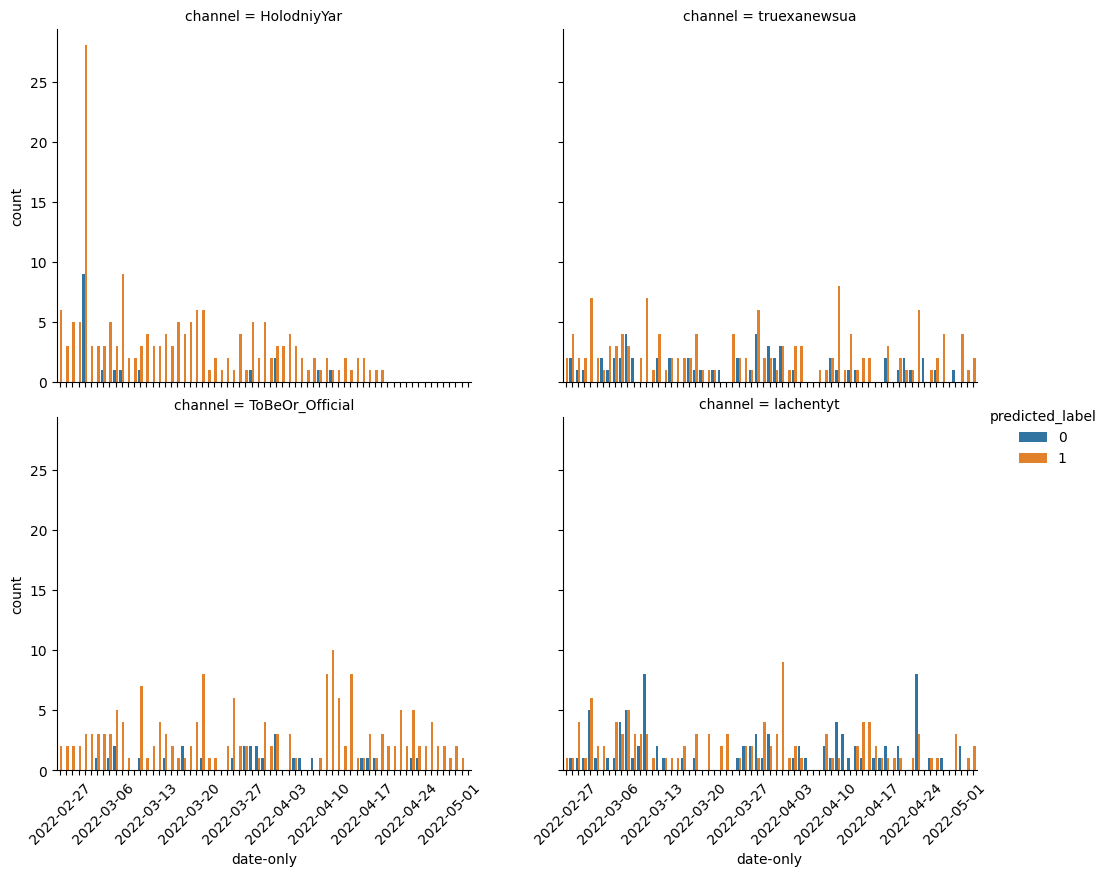

In [ ]:

translator = Translator()

start_date = '2022-02-24'
end_date = '2022-05-01'

first_months_df = calculate_time_dynamics(story_df,
                                     start_date=start_date,
                                     end_date=end_date,
                                     model=model,
                                     tokenizer=tokenizer,
                                     batch_size=batch_size,
                                     device=device)

plot_messages_by_date(first_months_df, hue='predicted_label', col_order=['HolodniyYar', 'truexanewsua', 'ToBeOr_Official', 'lachentyt' ])
display(result_matrix(first_months_df, ['channel'],metrics ))
display(first_months_df.groupby('channel').apply(partial(sample_tp_fn, sample_size=2))[['text', 'label', 'predicted_label']])

In [ ]:
display(first_months_df.groupby('channel').apply(partial(sample_tp_fn, sample_size=1))[['text', 'label', 'predicted_label','original_text']])

: 

In [ ]:
output_df = (result_matrix(first_months_df, ['channel'],metrics )
 .reset_index()
 .set_index(['label'])
 .sort_index()[['channel', 'recall']]
 .rename(columns={'channel' : 'Channel', 'recall' : 'Recall Score'})
 )
output_df.index.name = 'Label'
print(output_df.to_latex())

: 

In [ ]:
first_months_df.set_index('date').sort_index()

: 

In [ ]:
'''
Right now to illustrate how model performs I just output the count of the messages each day
What I want to communicate is how many messages were written in the channel on that day
and what percentage what classified and how

I image a plot that has days or a couple of days combined on the x
and bars stacked on top of each other

Cons: communicates percentage and the count

I want a count plot of messages and one bar has two colors depending 
on the percentage of the particular class
'''

: 

In [ ]:
# plt.figure(dpi=1200)
fig, ax = plt.subplots()
message_counts = (first_months_df
                  .set_index('date')
                  .groupby(['predicted_label']).
                  resample('7d')
                  .count()['text'])

total_daily = message_counts.reset_index().groupby('date')['text'].sum()

secion_indices = [0, 1]
bottom = np.zeros(len(message_counts) // 2)
width = 5
for i in secion_indices:
    bars = ax.bar(message_counts.loc[i].index, message_counts.loc[i].values, 
        width=width,
           label=i,
          bottom=bottom)
    
    
    percentage = message_counts.loc[i] / total_daily * 100
    for bar_i, bar in enumerate(bars):
        text = f'{percentage.iloc[bar_i].astype(int)}%'
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,  bottom[bar_i]+ yval / 2, text, 
        va='center', ha='center', color='white')
        
    bottom += message_counts.loc[i].values
    
plt.xticks(rotation=45)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


# plt.grid()
plt.xlabel('Date')
plt.ylabel('Number of messages')
plt.title('Amount of messages predicted by the model');

# We need to have array of bottom rows that is messages 
# we need to have array of above rows

# output the score by day (nice idea!!!, well done)
plt.savefig('test.pdf')

: 

: 

In [ ]:
# Plot with precision scores for each channel
# I want to have a function that will draw a bar plot at specified axis
# The function should accept a set of labels, a set of values and a set of text 
# for each value

# plt.figure(dpi=1200)

def stacked_bar_plot(xtick_labels, values, bar_texts, legend_labels, inversed_legend_order=True, ax=None,
                    colors=None):

    if ax is None:
        _, ax = plt.subplots()
        


    m, n = values.shape
    bottom = np.zeros(n)
    width = 5
    
    bar_kwargs = [{} for _ in range(n)]
    if colors is not None:
        for i in range(m):
            bar_kwargs[i]['color'] = colors[i]

    for i in range(m):
        bar_values = values[i]
        bars = ax.bar(xtick_labels, bar_values, 
            width=width,
            label=legend_labels[i],
            bottom=bottom,
                     **bar_kwargs[i])

        for j in range(len(bars)):
            bar = bars[j]
            text = bar_texts[i, j]
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2,  bottom[j]+ yval / 2, text, 
            va='center', ha='center', color='white')

        bottom += bar_values

        
    plt.xticks(xtick_labels, rotation=45)

    if inversed_legend_order:
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [1, 0]
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])



: 

In [ ]:
ncol = 2
nrow = 3

plt.figure(figsize=(16, 10))

for idx, channel in enumerate(first_months_df.channel.unique()):
    channel_df = first_months_df[first_months_df['channel'] == channel]
    ax = plt.subplot(nrow, ncol, idx + 1)
    
    message_counts = (channel_df
                      .set_index('date')
                      .groupby(['predicted_label']).
                      resample('7d')
                      .count()['text'])

    total_daily = message_counts.reset_index().groupby('date')['text'].sum()
    xtick_labels = message_counts.loc[0].index
    display(message_counts)
    values = np.array([
        message_counts.loc[0].values,
        message_counts.loc[1].values
    ])
    bar_precents = np.array([
         message_counts.loc[0] / total_daily * 100,
        message_counts.loc[1] / total_daily * 100
    ])
    bar_texts = np.vectorize(lambda x: f"{x:.0f}%")(bar_precents)
    legend_labels = [
        'Non-propaganda',
        'Propaganda'
    ]
    # draw this for each 
    stacked_bar_plot(
        xtick_labels,
        values,
        bar_texts,
        legend_labels,
        ax=ax
    )
    ax.set_title(f'Channel {channel}')
    
plt.tight_layout()

: 

In [ ]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Change this to "pdflatex" or "lualatex"
})

: 

In [ ]:
first_months_df.query('channel == "truexanewsua"').set_index(['date']).resample('7d')['predicted_label'].mean()

: 

In [ ]:
ncol = 2
nrow = 3

plt.figure(figsize=(16, 10))
colors=['r', 'g']
first_months_df['correct_prediction'] = (first_months_df['label'] == first_months_df['predicted_label']).astype(int)
for idx, channel in enumerate(first_months_df.channel.unique()):
    channel_df = first_months_df[first_months_df['channel'] == channel]
    ax = plt.subplot(nrow, ncol, idx + 1)
    
    message_counts = (channel_df
                      .set_index('date')
                      .groupby(['correct_prediction'])
                      .resample('7d')
                      .count()['text'])

    total_daily = message_counts.reset_index().groupby('date')['text'].sum()
    xtick_labels = message_counts.loc[0].index

    print(channel)
    print(message_counts.loc[0])
    print(message_counts.loc[1])
    values = np.array([
        message_counts.loc[0].values,
        message_counts.loc[1].values
    ])
    bar_precents = np.array([
         message_counts.loc[0] / total_daily * 100,
        message_counts.loc[1] / total_daily * 100
    ])
    bar_texts = np.vectorize(lambda x: f"{x:.0f}%")(bar_precents)
    legend_labels = [
        'FP',
        'TP'
    ]
    # draw this for each 
    stacked_bar_plot(
        xtick_labels,
        values,
        bar_texts,
        legend_labels,
        ax=ax,
        colors=colors
    )
    ax.set_title(f'Channel {channel}')
    
plt.tight_layout()
# plt.savefig('plot.pgf')
# plt.close()

: 

In [ ]:
# draw the same graph but for the model precision

: 

In [ ]:

# result_matrix(sampled_inf_df.assign(
#     predicted_label=inference_df_en_preds
# ), ['channel'],metrics )

: 

In [ ]:
# ru_1_df = sampled_inf_df.assign(
#     predicted_label=inference_df_en_preds
# ).query('channel == "HolodniyYar"')
# recall_score(ru_1_df['label'], ru_1_df['predicted_label'], average=None)

: 

In [ ]:
# condlist = [
#     sampled_inf_df['channel'].isin([
#         'ToBeOr_Official',
#         'lachentyt',
#         'truexanewsua'
#     ]),
#     sampled_inf_df['channel'].isin(['HolodniyYar']),
# ]
# valuelist = [0, 1]

# result_matrix(
#     sampled_inf_df.assign(
#         label=np.select(
#             condlist,
#             valuelist
#         ),
#         predicted_label=inference_df_en_preds
#     )
# )

: 

In [ ]:
# Do the same for other channel


# sampled_inf_df.assign(
#     predicted_label=inference_df_en_preds
# ).groupby('channel').apply(partial(sample_tp_fn, sample_size=2))[['text', 'label', 'predicted_label']]

: 

### Test 3. Present days with translation

In [ ]:
start_date = '2023-12-01'
end_date = '2024-02-08'
inference_df = story_df.loc[start_date:end_date].reset_index('date')
inference_df['date-only'] = inference_df['date'].dt.date
plot_messages_by_date(inference_df)

: 

In [ ]:
# dec_jan_24 = calculate_time_dynamics(story_df,
#                                      start_date='2024-01-01',
#                                      end_date='2024-02-08',
#                                      model=model,
#                                      tokenizer=tokenizer,
#                                      batch_size=batch_size,
#                                      device=device)

# plot_messages_by_date(dec_jan_24, hue='predicted_label', col_order=['HolodniyYar', 'truexanewsua', 'ToBeOr_Official', 'lachentyt' ])
# print(result_matrix(dec_jan_24, ['channel'],metrics ))
# print(dec_jan_24.groupby('channel').apply(partial(sample_tp_fn, sample_size=2))[['text', 'label', 'predicted_label']])

: 

In [ ]:

translator = Translator()

start_date = '2023-12-01'
end_date = '2024-02-08'

current_time_df = calculate_time_dynamics(story_df,
                                     start_date=start_date,
                                     end_date=end_date,
                                     model=model,
                                     tokenizer=tokenizer,
                                     batch_size=batch_size,
                                     device=device)

plot_messages_by_date(current_time_df, hue='predicted_label', col_order=['HolodniyYar', 'truexanewsua', 'ToBeOr_Official', 'lachentyt' ])
display(result_matrix(current_time_df, ['channel'],metrics ))
display(current_time_df.groupby('channel').apply(partial(sample_tp_fn, sample_size=2))[['text', 'label', 'predicted_label']])

: 

## Analysis of particular news topics

In [ ]:
## 11 Nov
# Find all text messages that contains херсон in it 
# any more efficient ways to do it
def get_rows_that_contain_topic(df, start_date, end_date, keywords):
    df = df.loc[start_date:end_date]
    keywords = set(keywords)
    
    def contains_topic(text) -> bool:
        for i in text.lower().split():
            if i in keywords:
                return True
            
        return False
    return df[df['text'].apply(contains_topic)]
    

: 

In [ ]:
# This keywords were generated by ChatGPT

keywords = ["херсон", "херсона", "херсону", "херсон", "херсоном", "херсоні", "херсоне"]
kherson_df = get_rows_that_contain_topic(story_df,
                           start_date='2022-10-01',
                           end_date='2022-12-01',
                           keywords=keywords)
kherson_df.index.name = 'date'
kherson_df.groupby(['channel','label'])['text'].agg('count')
kherson_df = calculate_time_dynamics(kherson_df,
                                     start_date='2022-10-01',
                                     end_date='2022-12-01',
                                     model=model,
                                     tokenizer=tokenizer,
                                     batch_size=batch_size,
                                     device=device)

plot_messages_by_date(kherson_df, hue='predicted_label', col_order=['HolodniyYar', 'truexanewsua', 'ToBeOr_Official', 'lachentyt' ])
print(result_matrix(kherson_df, ['channel'],metrics ))
kherson_df.groupby('channel').apply(partial(sample_tp_fn, sample_size=1))[['text', 'original_text', 'label', 'predicted_label']]

: 

In [ ]:
output_df = (result_matrix(first_months_df, ['channel'],metrics )[['recall']]
    .merge(result_matrix(kherson_df, ['channel'],metrics)[[ 'recall']],on=['label','channel'], 
        suffixes=('', ' Kherson Sample'))
    .merge(result_matrix(current_time_df, ['channel'],metrics)[[ 'recall']],on=['label','channel'], 
        suffixes=(' Fist Month', ' Current Time'))
    .reset_index()
    .rename(columns={
        'recall Fist Month': 'Recall First Months',
        'recall Kherson Sample': 'Recall Kherson Sample',
        'recall Current Time': 'Recall Current Time',
    })
    .set_index(['label', 'channel'])
            .sort_index(ascending=[True, True])
             
#  .sort_index()[['recall']]
#  .rename(columns={ 'recall' : 'Recall Score'})
 )

output_df.index.names = ['Label', 'Channel']
# print(output_df.to_latex(float_format='%.2f'))
output_df

: 

# Playground (this can be deleted)

In [ ]:
def read_experiment_data(experiment_data_path):
    X_train = pd.read_csv(f'{experiment_data_path}/X_train.csv')
    X_test = pd.read_csv(f'{experiment_data_path}/X_test.csv')
    X_eval = pd.read_csv(f'{experiment_data_path}/X_eval.csv')

    y_train_preds = pd.read_csv(f'{experiment_data_path}/y_train_preds.csv')
    y_test_preds = pd.read_csv(f'{experiment_data_path}/y_test_preds.csv')
    y_eval_preds = pd.read_csv(f'{experiment_data_path}/y_eval_preds.csv')
    X = pd.concat([
        X_train.assign(
            predicted_label=y_train_preds.values,
            subset='train'
        ),
        X_test.assign(
            predicted_label=y_test_preds.values,
            subset='test'
        ),
        X_eval.assign(
            predicted_label=y_eval_preds.values,
            subset='eval'
        )
        ])
    return X



: 

In [ ]:
from IPython.display import display
ex1 = read_experiment_data('/kaggle/input/predictions-from-the-working-model')
display()

: 

In [ ]:
def style_multilevel(df, level=0, prop='border-bottom: 2px solid black;'):
    """
    Apply a style to multi-level column headers.
    
    Args:
    df (DataFrame): The DataFrame to style.
    level (int): The level of the multi-index to apply the style to.
    prop (str): The CSS property to apply.
    """
    # Check if DataFrame has a multi-index
    if isinstance(df.columns, pd.MultiIndex):
        # Generate the styles for each column
        return df.style.apply(lambda x: [''] + [prop if i else '' for i in df.columns.get_level_values(level).duplicated(keep='first')], axis=1)
    else:
        return df.style
   

# Apply the styling function



: 

In [ ]:
ex1_res_df= (result_matrix(
            ex1, 
              ['sourced_lang'], 
              {k:v for k,v in metrics.items() if k in ['precision', 'recall', 'f1', 'count']}, 
              use_subsets=True
             )
    .T
    .reset_index()
    .set_index(['subset', 'level_0'])
    .sort_index(ascending=[False, False])
    .T)

ex1_res_df.round(2)

: 

In [ ]:
ex1_res_df.columns.names = ['subset' ,'metrics']
print(ex1_res_df.to_latex(float_format='%.2f'))

: 

In [ ]:
ex1.groupby(['label', 'sourced_lang'])['channel'].unique().apply(lambda x: len(x))

: 

## Exploring model choices

In [ ]:
explore_model_choices(first_months_df)

: 

In [ ]:
print(pd.DataFrame([
    {
        'Channel': 'HolodniyYar',
        'Presumed label': 1,
        'Predicted label': 0,
        'Original text': 'Верное решение. Семьи ждут их дома!',
        'Translated text': 'The families are waiting for them at home!'
    },
        {
        'Channel': 'HolodniyYar',
        'Presumed label': 1,
        'Predicted label': 0,
        'Original text': '❗️Кажется для властей Украины всё\n\nНеожиданно на спутниковых снимках от Maxar Technologies увидели колонну бронетехники длинной 64 км свыше чуть западнее Киева. \n\nДлина колонны по данным Maxar составляет порядка 64 км🤷‍♂\n\nКак и предупреждали Зеленского, за безответственность настанет расплата, а за самообман расплата бывает самой горькой.\n\nНапомним, уже с завтрашнего дня ВС РФ может начать отлов военных преступников с помощью серий спецмероприятий',
        'Translated text': 'It seems to the Ukrainian authorities that all of the satellite images from Maksar Technologies have seen a column of armoured equipment of a length of 64 km over just west of Kiev. The length of the column, according to the data from Makhar, is about 64 km. As Zelensky was warned, there will be a payback for irresponsibleness, and self-deception can be the bitterest'
    },
        
        {
        'Channel': 'HolodniyYar',
        'Presumed label': 1,
        'Predicted label': 1,
        'Original text': ' ⚡️⚡️⚡️🇺🇦 Вот тебе и допомога!\n\nЯ писал раньше про то, что Германия поставит нам тяжелое вооружение сомнительного качества. Но они превзошли себя!\n\nГермания по указанию канцлера Шольца исключила из списка военной помощи Украине все тяжелое вооружение, список сократился с 48 до 24 страниц - передает немецкое издание Билд.\n\nОчередной пафосный жест Европы пошел ко дну! \n\n@HolodniyYar',
        'Translated text': "I've written earlier about the fact that Germany will give us a difficult weapon of questionable quality, but they have outdone themselves! Germany, at the instruction of Chancellor Scholtz, has removed all heavy weapons from Ukraine's military assistance list, the list has been reduced from 48 to 24 pages - transmitting the German edition of Bild. Europe's next pathological gesture has gone down! @HolodnyYar"
    }
])[[ 'Channel','Presumed label', 'Predicted label', 'Translated text']].to_latex())

: 

In [ ]:
explore_model_choices(current_time_df)

: 

In [ ]:
lala_df=  pd.DataFrame({
        'text': [
        "I've written earlier about the fact that Germany will give us a difficult \
            weapon of questionable quality, but they have outdone themselves! Germany, \
            at the instruction of Chancellor Scholtz, has removed all heavy weapons\
            from Ukraine's military assistance list, the list has been reduced from 48 to 24 pages -\
            transmitting the German edition of Bild. Europe's next \
            pathological gesture has gone down! @s"
        ],
        'label': [1]
    })
# display(translator.translate(['❗️Кажется для властей Украины всё'], source_lang='ru')[0])
score_test, X_test_preds = get_model_score_and_predictions(
    model,
    tokenizer,
  lala_df,
    batch_size=batch_size
)
X_test_preds

: 

: 